In [62]:
# generic imports for making a synth ccd image
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')
import numpy as np
import scipy as sp
import pylab as plt
plt.rcParams['image.origin'] = 'lower' 
from photutils.aperture import EllipticalAperture
import cmath
import math
from astropy.io import fits
from turbustat.simulator import make_extended
from scipy.signal import convolve
from astropy.convolution import AiryDisk2DKernel

In [2]:
%run functions.py

### Blank Image

In [3]:
# file full of zeros of the desired width and height
synthetic_image = np.zeros([1000, 1000])

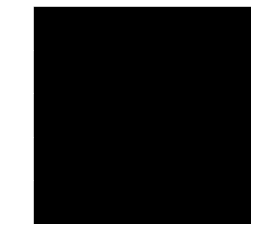

In [4]:
plt.imshow(synthetic_image, cmap='gray', origin='lower')

### Adding readnoise

In [5]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = np.random.normal(scale=amount/gain, size=shape)
    
    return noise

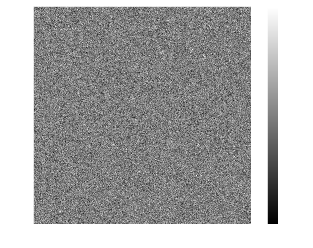

In [6]:
plt.figure()
noise_im = synthetic_image + read_noise(synthetic_image, 5)
plt.imshow(noise_im, cmap='gray', origin='lower')
plt.colorbar()

### Adding bias

In [7]:
def bias(image, value, realistic=False):
    """
    Generate simulated bias image.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some columns with somewhat higher bias value (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant offset!
    bias_im = np.zeros_like(image) + value
    
    # If we want a more realistic bias we need to do a little more work. 
    if realistic:
        shape = image.shape
        number_of_colums = 5
        
        # We want a random-looking variation in the bias, but unlike the readnoise the bias should 
        # *not* change from image to image, so we make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])
        
        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern
            
    return bias_im
        

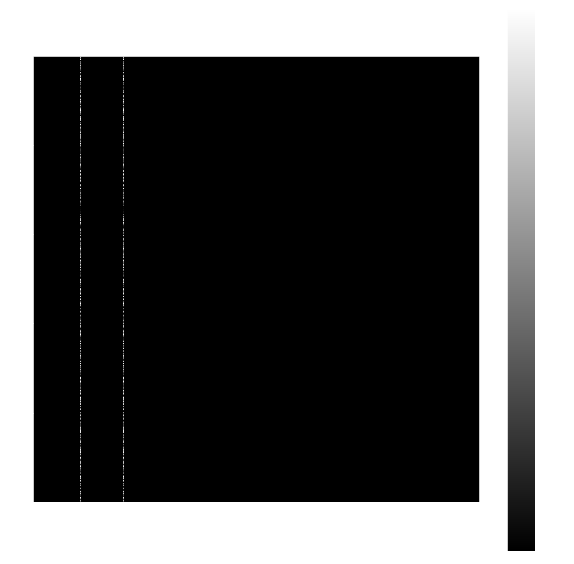

In [8]:
bias_only = bias(synthetic_image, 1100, realistic=True)
plt.figure(figsize=(10,10))
plt.imshow(bias_only, cmap='gray', origin='lower')
plt.title('Bias alone, bad columns included', fontsize='20')
plt.colorbar()

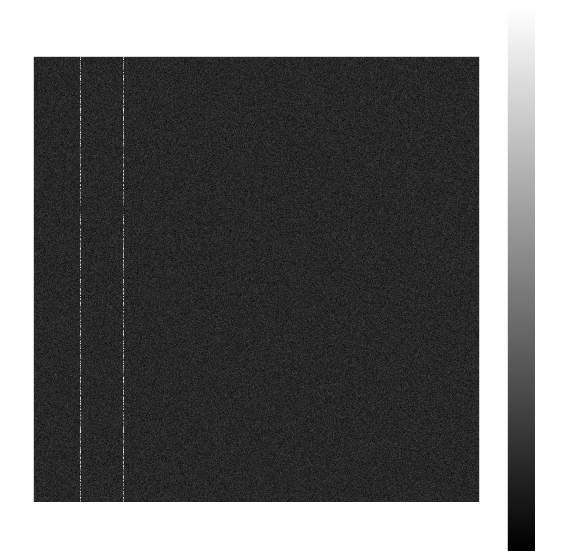

In [9]:
bias_noise_im = noise_im + bias_only
plt.figure(figsize=(10,10))
plt.imshow(bias_noise_im, cmap='gray')
plt.title('Realistic bias frame (includes read noise)', fontsize='20')
plt.colorbar()

### Dark current

In [10]:
def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically 
        report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    strength : float, optional
        Pixel count in the cosmic rays.    
    """
    
    # dark current for every pixel; we'll modify the current for some pixels if 
    # the user wants hot pixels.
    base_current = current * exposure_time / gain
    
    # This random number generation should change on each call.
    dark_im = np.random.poisson(base_current, size=image.shape)
        
    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high but should 
        # ensure they are visible.
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.0001 * x_max * y_max)
        
        # Like with the bias image, we want the hot pixels to always be in the same places
        # (at least for the same image size) but also want them to appear to be randomly
        # distributed. So we set a random number seed to ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 10000 * current
        
        dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain
    return dark_im

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


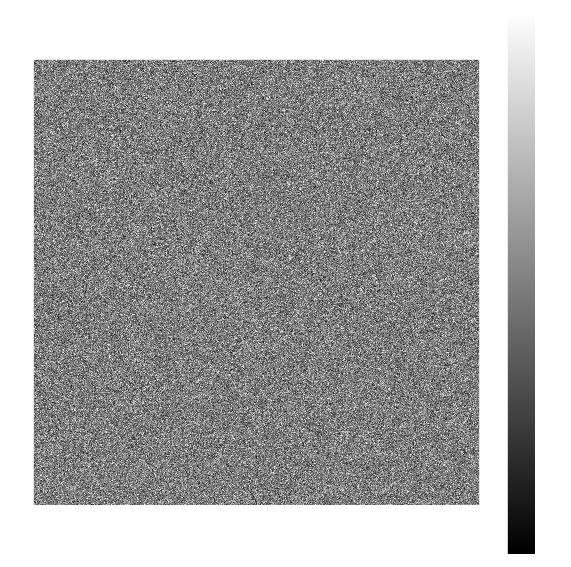

In [11]:
dark_exposure = 100
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels=True)
plt.figure(figsize=(10,10))
plt.imshow(dark_only, cmap='gray', vmin=0, vmax=20)
title_string = 'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'.format(dark_cur=dark_cur, dark_exposure=dark_exposure)
plt.title(title_string, fontsize='20');
plt.colorbar()

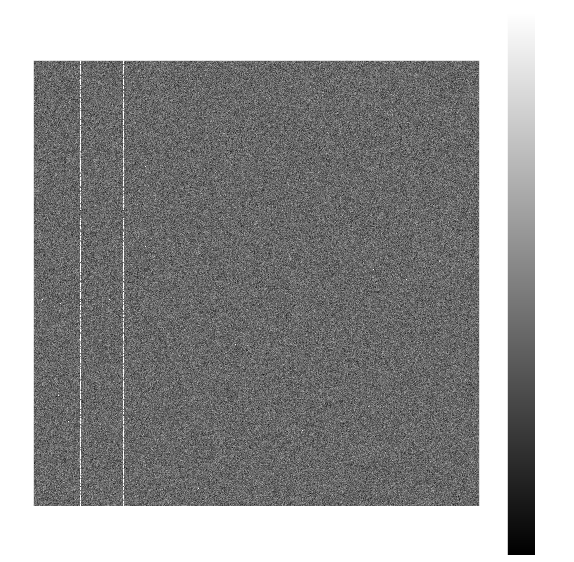

In [12]:
dark_bias_noise_im = bias_noise_im + dark_only
plt.figure(figsize=(10,10))
plt.imshow(dark_bias_noise_im, cmap='gray', vmax=1150)
plt.title('Realistic dark frame \n(with bias, read noise)', fontsize='20')
plt.colorbar()

### Sky background

In [13]:
def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the image (because
    some times Moons happen).
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or 
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = np.random.poisson(sky_counts * gain, size=image.shape) / gain
    
    return sky_im

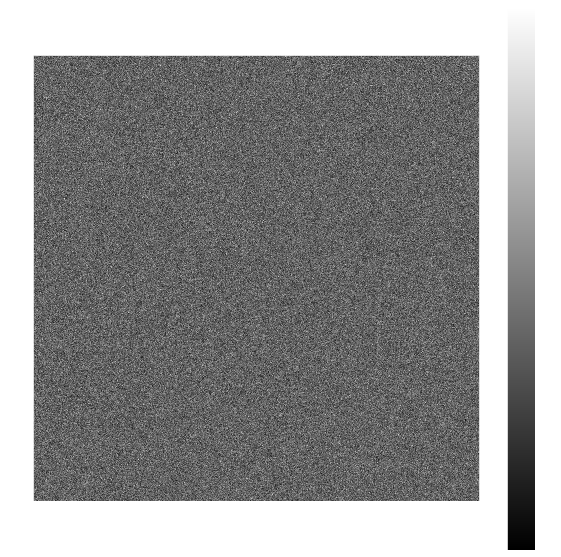

In [14]:
sky_level = 20
sky_only = sky_background(synthetic_image, sky_level)
plt.figure(figsize=(10,10))
plt.imshow(sky_only, cmap='gray')
plt.title('Sky background only, {} counts input'.format(sky_level), fontsize=20)
plt.colorbar()

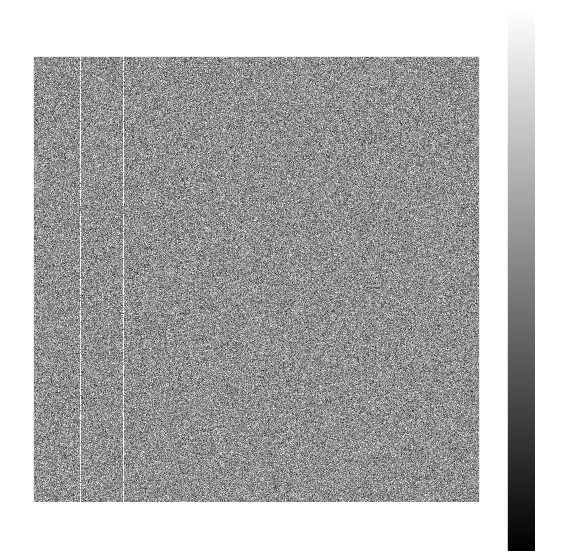

In [15]:
sky_dark_bias_noise_im = dark_bias_noise_im + sky_only
plt.figure(figsize=(10,10))
plt.imshow(sky_dark_bias_noise_im, cmap='gray', vmax=1155)
plt.title('Sky, dark, bias and noise\n(Realistic image of clouds)', fontsize=20);
plt.colorbar()

### Stars

In [16]:
def stars(image, number, max_counts=10000, gain=1):
    """
    Add some stars to the image.
    """
    from photutils.datasets import make_random_gaussians_table, make_gaussian_sources_image
    # Most of the code below is a direct copy/paste from
    # https://photutils.readthedocs.io/en/stable/_modules/photutils/datasets/make.html#make_100gaussians_image
    
    flux_range = [max_counts/100, max_counts]
    
    y_max, x_max = image.shape
    xmean_range = [0.1 * x_max, 0.9 * x_max]
    ymean_range = [0.1 * y_max, 0.9 * y_max]
    xstddev_range = [1, 4]
    ystddev_range = [1, 4]
    params = dict([('amplitude', flux_range),
                  ('x_mean', xmean_range),
                  ('y_mean', ymean_range),
                  ('x_stddev', xstddev_range),
                  ('y_stddev', ystddev_range),
                  ('theta', [0, 2*np.pi])])

    sources = make_random_gaussians_table(number, params,
                                          random_state=12345)
    
    star_im = make_gaussian_sources_image(image.shape, sources)
    
    return star_im

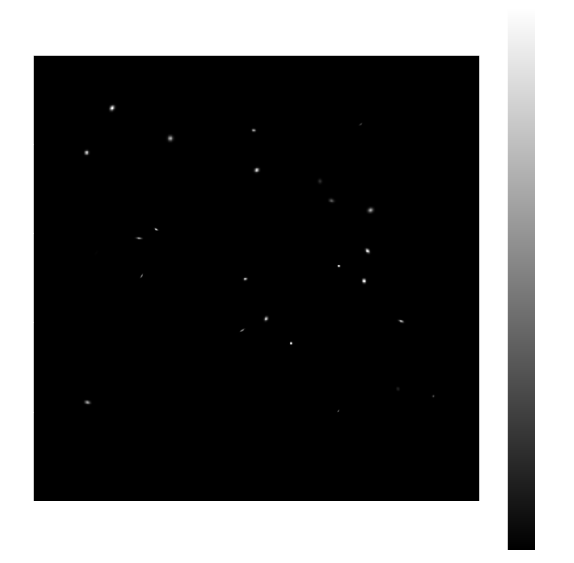

In [17]:
stars_only = stars(synthetic_image, 25, max_counts=2000)
plt.figure(figsize=(10,10))
plt.imshow(stars_only, cmap='gray')
plt.title('Stars only'.format(stars_only), fontsize=20)
plt.colorbar()

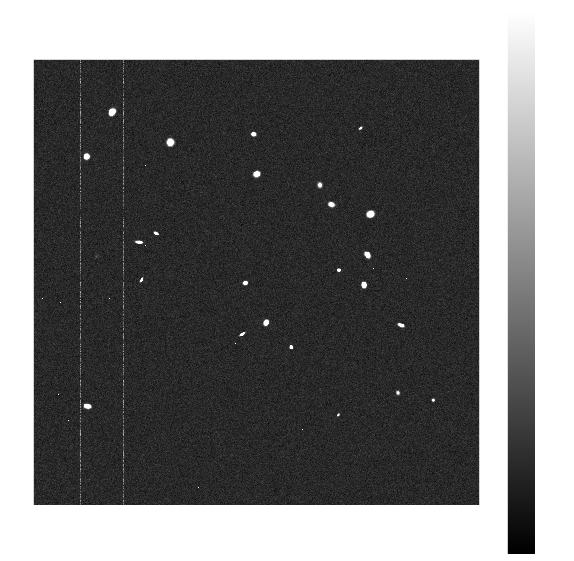

In [18]:
stars_with_background = sky_dark_bias_noise_im + stars_only
plt.figure(figsize=(10,10))
plt.imshow(stars_with_background, cmap='gray', vmax=1300)
plt.title('Stars with noise, bias, dark, sky'.format(stars_with_background), fontsize=20)
plt.colorbar()

### Testing data

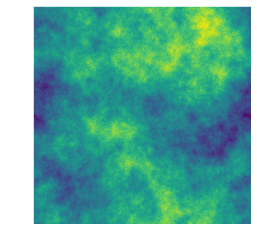

In [19]:
turbulent_synth = make_extended(1000, powerlaw=3.)
plt.imshow(turbulent_synth)

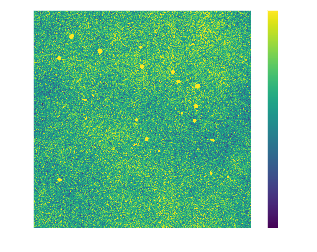

In [20]:
turbulent_im = turbulent_synth + stars_with_background
plt.imshow(turbulent_im, vmax=1150)
plt.colorbar()

#### Airy Function

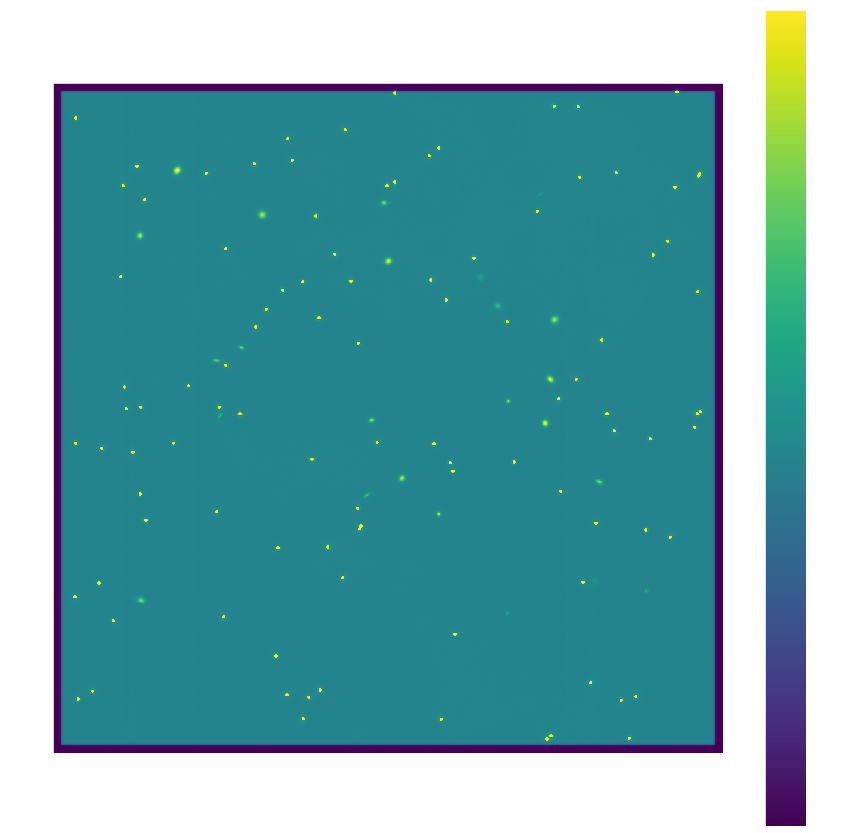

In [21]:
from astropy.convolution import AiryDisk2DKernel
fwhm = 2.35/0.75

airystars = convolve(turbulent_im, AiryDisk2DKernel(fwhm))
plt.figure(figsize=(15,15))
plt.imshow(airystars, interpolation='none', origin='lower', vmax=2500)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

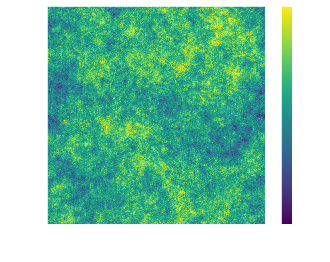

In [22]:
starstest = stars(synthetic_image, 25, max_counts=2500) + dark_bias_noise_im
turbulence = make_extended(1000, powerlaw=2)
turbulenttest = turbulence + starstest
plt.imshow(turbulence, interpolation='none', origin='lower', vmax=0.5)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

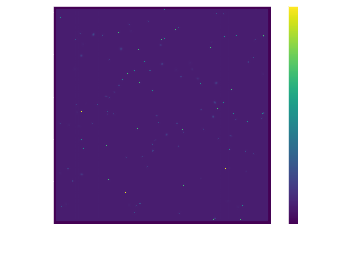

In [23]:
airystarstest = convolve(starstest, AiryDisk2DKernel(fwhm))
plt.imshow(airystarstest, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

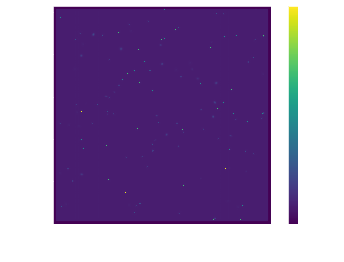

In [24]:
airyturbtest = convolve(turbulenttest, AiryDisk2DKernel(fwhm))
plt.imshow(airyturbtest, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

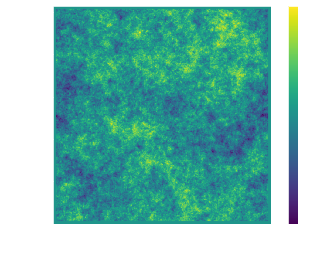

In [25]:
testtest = airyturbtest - airystarstest
plt.imshow(testtest, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

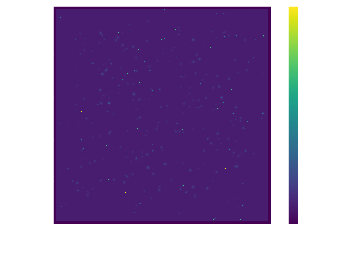

In [26]:
starstest2 = stars(synthetic_image, 250, max_counts=2500) + dark_bias_noise_im
turbulenttest2 = turbulence + starstest2
airystarstest2 = convolve(AiryDisk2DKernel(fwhm), starstest2)
plt.imshow(airystarstest2, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

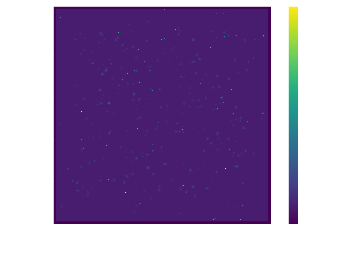

In [27]:
airyturbtest2 = convolve(AiryDisk2DKernel(fwhm), turbulenttest2)
plt.imshow(airyturbtest2, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

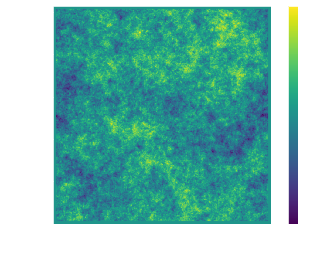

In [28]:
testtest2 = airyturbtest2 - airystarstest2
plt.imshow(testtest2, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

Text(0.5, 1.0, '250 stars')

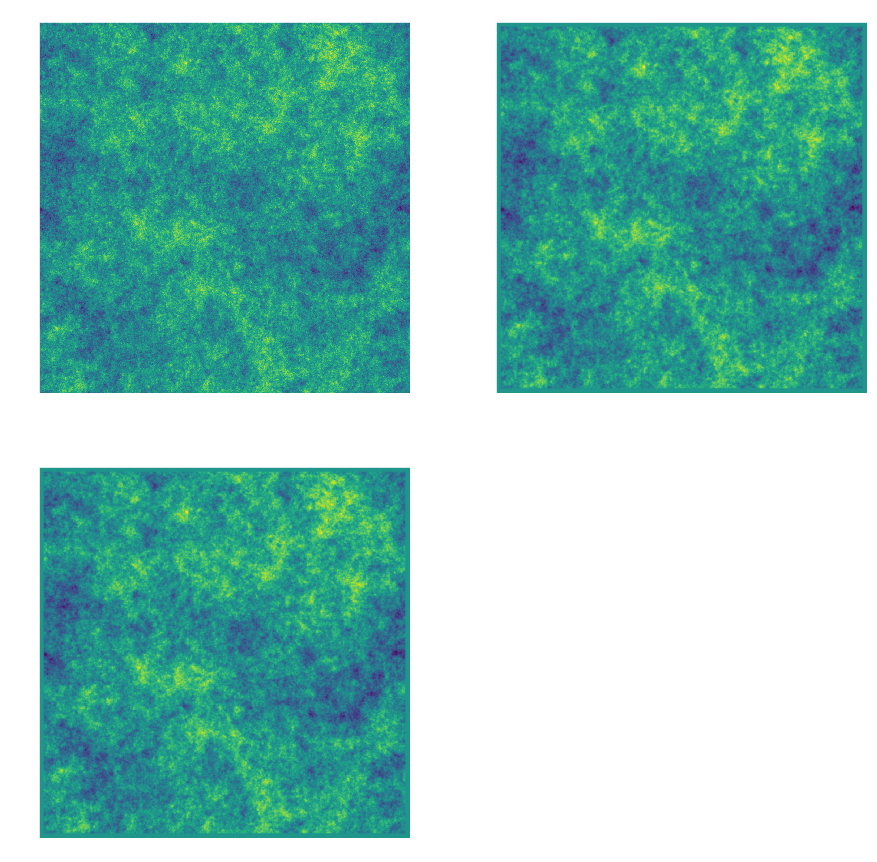

In [29]:
plt.figure(figsize=(15,15))
ax = plt.subplot(2,2,1)
ax.imshow(turbulence, origin='lower')
ax.set_title("Regular")
ax = plt.subplot(2,2,2)
ax.imshow(testtest, origin='lower')
ax.set_title("25 stars")
ax = plt.subplot(2,2,3)
ax.imshow(testtest2, origin='lower')
ax.set_title("250 stars")

#### Fourier Transform

In [30]:
ftest1 = np.fft.fft2(turbulenttest2) ##turbulence and stars and noise
ftest_turbulence_stars = (np.fft.ifft2(ftest1)).real
ftest2 = np.fft.fft2(starstest) #just stars and noise 
ftest_stars_only = (np.fft.ifft2(ftest2)).real
ftest = ftest_turbulence_stars - ftest_stars_only
ftest3 = np.fft.fft2(turbulence) ##+ np.exp(-2j*np.pi*np.random.rand(1000,1000))
ftestno = (np.fft.ifft2(ftest3)).real

Text(0.5, 1.0, 'Stars and Turbulence')

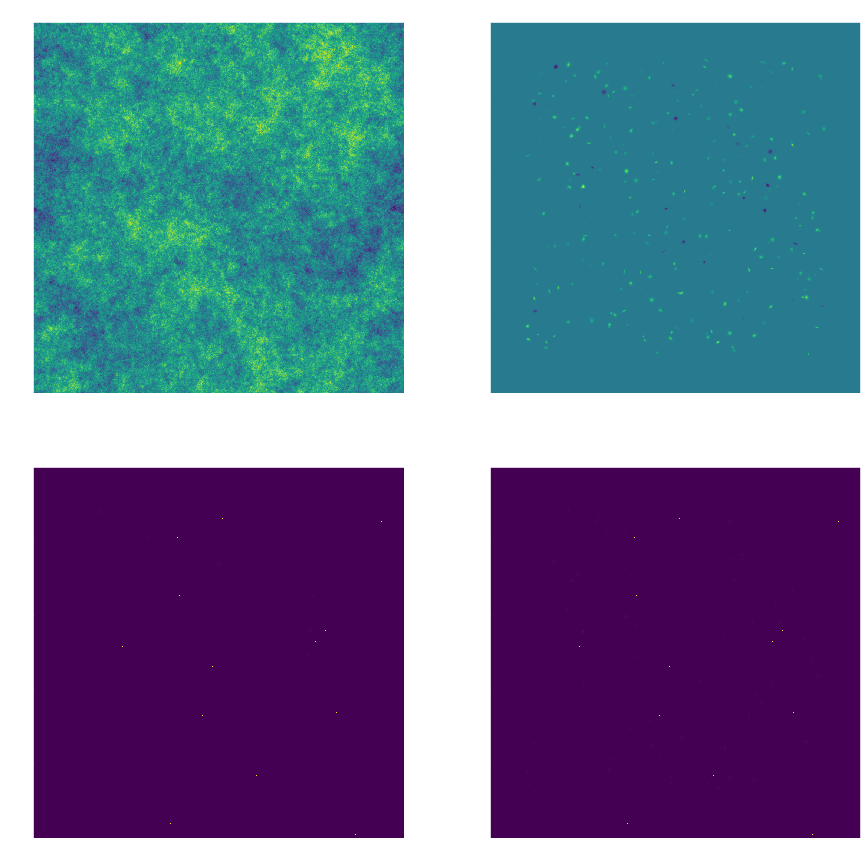

In [31]:
plt.figure(figsize=(15,15))
ax = plt.subplot(2,2,1)
ax.imshow(ftestno, origin='lower')
ax.set_title("Fourier Only")
ax = plt.subplot(2,2,2)
ax.imshow(ftest, origin='lower')
ax.set_title("Fourier Subtracted")
ax = plt.subplot(2,2,3)
ax.imshow(ftest_stars_only, origin='lower')
ax.set_title("Stars Only")
ax = plt.subplot(2,2,4)
ax.imshow(ftest_turbulence_stars, origin='lower')
ax.set_title("Stars and Turbulence")

Text(0.5, 1.0, '250 stars')

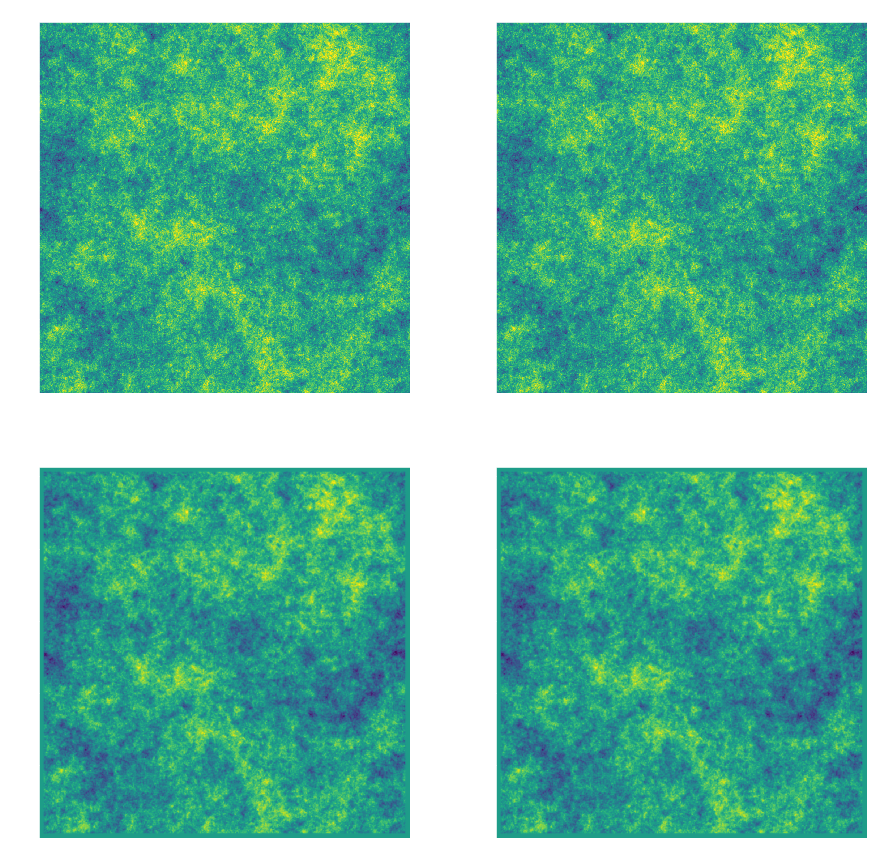

In [32]:
plt.figure(figsize=(15,15))
ax = plt.subplot(2,2,1)
ax.imshow(turbulence, origin='lower', vmax=0.5)
ax.set_title("Regular")
ax = plt.subplot(2,2,2)
ax.imshow(ftestno, origin='lower', vmax=0.5)
ax.set_title("Fourier Only")
ax = plt.subplot(2,2,3)
ax.imshow(testtest, origin='lower', vmax=0.5)
ax.set_title("25 stars")
ax = plt.subplot(2,2,4)
ax.imshow(testtest2, origin='lower', vmax=0.5)
ax.set_title("250 stars")

In [33]:
ftest4 = np.fft.fft2(turbulenttest2) + np.exp(-2j*np.pi*np.random.rand(1000,1000))
stars_turb_noise = (np.fft.ifft2(ftest4)).real
ftest5 = np.fft.fft2(starstest) + np.exp(-2j*np.pi*np.random.rand(1000,1000))
stars_noise = (np.fft.ifft2(ftest5)).real
turb_subtraction = stars_turb_noise - stars_noise
ftest6 = np.fft.fft2(turbulence) + np.exp(-2j*np.pi*np.random.rand(1000,1000))
turb_noise = (np.fft.ifft2(ftest6)).real

Text(0.5, 1.0, 'Stars and Turbulence and Noise')

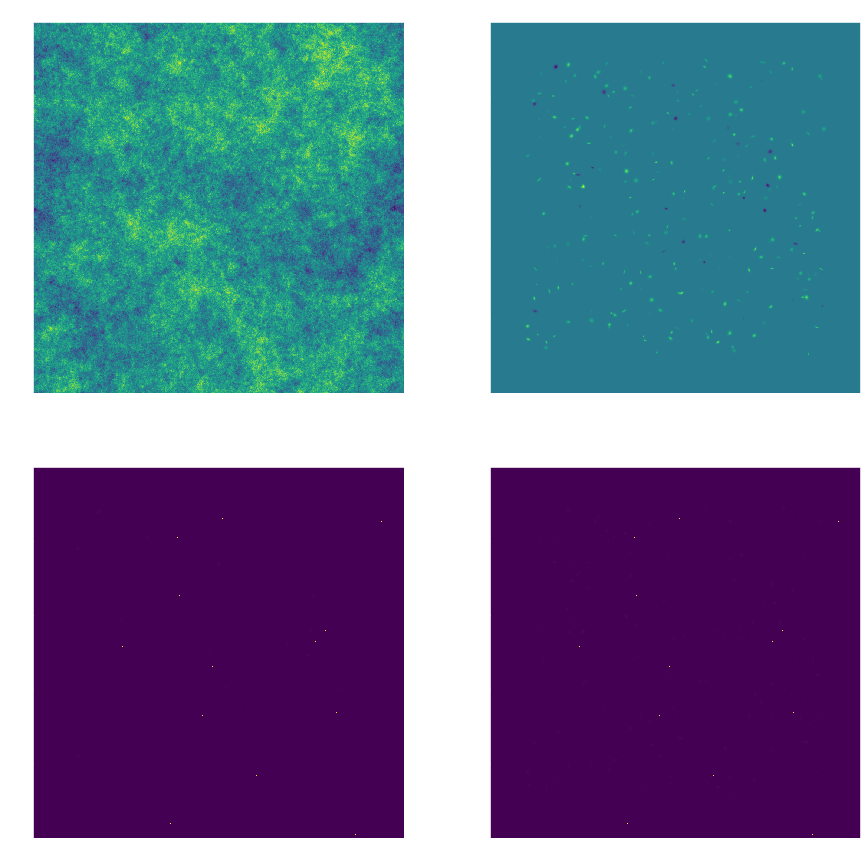

In [34]:
plt.figure(figsize=(15,15))
ax = plt.subplot(2,2,1)
ax.imshow(turb_noise, origin='lower')
ax.set_title("Fourier and Noise Only")
ax = plt.subplot(2,2,2)
ax.imshow(turb_subtraction, origin='lower')
ax.set_title("Fourier Subtracted")
ax = plt.subplot(2,2,3)
ax.imshow(stars_noise, origin='lower')
ax.set_title("Stars and Noise")
ax = plt.subplot(2,2,4)
ax.imshow(stars_turb_noise, origin='lower')
ax.set_title("Stars and Turbulence and Noise")

### Comparing Flux

In [35]:
synth_stars, synth_sky, turbulent = make_turbulent_im(1000, 5, 1100, 0.1, 60, 20)

Text(0.5, 1.0, 'Starting Turbulence')

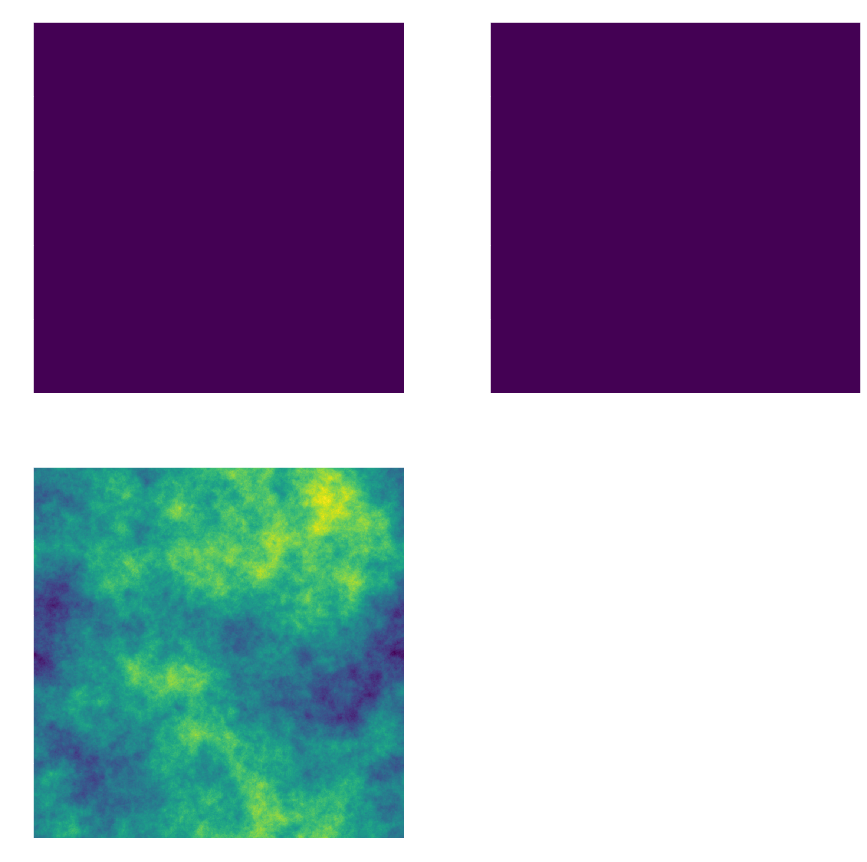

In [36]:
plt.figure(figsize=(15,15))
ax = plt.subplot(2,2,1)
ax.imshow(synth_stars, origin='lower')
ax.set_title("Stars Only")
ax = plt.subplot(2,2,2)
ax.imshow(synth_sky, origin='lower')
ax.set_title("Sky and Stars")
ax = plt.subplot(2,2,3)
ax.imshow(turbulent, origin='lower')
ax.set_title("Starting Turbulence")

In [37]:
turb_flux = turbulent.sum()
test_flux = (synth_sky - synth_stars).sum()
turb_flux, test_flux

(9406951.02005882, 9386651.91570897)

In [38]:
synth_stars_1, synth_sky_1, turbulent_1 = make_turbulent_im(1000, 5, 1100, 0.1, 60, 1)
turb_flux_1 = turbulent_1.sum()
test_flux_1 = (synth_sky_1 - synth_stars_1).sum()
turb_flux_1, test_flux_1

(9406951.02005882, 9386651.91570897)

In [39]:
synth_stars_10, synth_sky_10, turbulent_10 = make_turbulent_im(1000, 5, 1100, 0.1, 60, 10)
turb_flux_10 = turbulent_10.sum()
test_flux_10 = (synth_sky_10 - synth_stars_10).sum()
turb_flux_10, test_flux_10

(9406951.02005882, 9386651.91570897)

In [40]:
synth_stars_100, synth_sky_100, turbulent_100 = make_turbulent_im(1000, 5, 1100, 0.1, 60, 100)
turb_flux_100 = turbulent_100.sum()
test_flux_100 = (synth_sky_100 - synth_stars_100).sum()
turb_flux_100, test_flux_100

(9406951.02005882, 9386651.91570897)

In [41]:
synth_stars_1000, synth_sky_1000, turbulent_1000 = make_turbulent_im(1000, 5, 1100, 0.1, 60, 1000)
turb_flux_1000 = turbulent_1000.sum()
test_flux_1000 = (synth_sky_1000 - synth_stars_1000).sum()
turb_flux_1000, test_flux_1000

(9406951.02005882, 9386651.91570897)

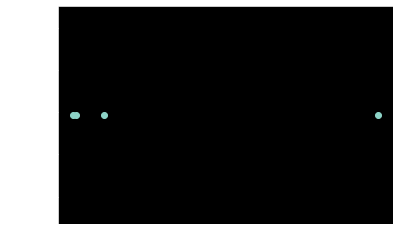

In [42]:
y_1 = [test_flux_1, test_flux_10, test_flux_100, test_flux_1000]
x_1 = [1, 10, 100, 1000]

plt.plot(x_1, y_1, 'o');

In [43]:
x = []
#y = []
for ii in range (50, 200):
#    synth_stars_ii, synth_sky_ii, turbulent_ii = make_turbulent_im(1000, 5, 1100, 0.1, 60, ii)
    x.append(ii)
#    test_flux_ii = (synth_sky_ii - synth_stars_ii).sum()
#    y.append(test_flux_ii)
#plt.plot(x, y, 'o', color='black');

In [44]:
turb_val = []
for ii in range(50,200):
    turb_val.append(turb_flux)
#plt.plot(x, y, 'o', color='black');
#plt.plot(x, turb_val, linestyle='-')

#### Testing bias amount

In [45]:
#x_2 = []
#y_2 = []
#for ii in range (50, 200):
#    synth_stars_ii, synth_sky_ii, turbulent_ii = make_turbulent_im(1000, 5, 1100 + 10*ii, 0.1, 60, 50)
#    x_2.append(1100 + 10*ii)
#    test_flux_ii = (synth_sky_ii - synth_stars_ii).sum()
#    y_2.append(test_flux_ii)
#plt.plot(x_2, y_2, 'o', color='black');

In [46]:
#plt.plot(x_2, y_2, 'o', color='black');
#plt.plot(x_2, turb_val, linestyle='-')

#### Testing random changes

In [47]:
#x_3 = []
#y_3 = []
#for ii in range (50, 200):
#    synth_stars_ii, synth_sky_ii, turbulent_ii = make_turbulent_im(1000, 5, 1100, 0.1, 60, 50)
#    x_3.append(ii-50)
#    test_flux_ii = (synth_sky_ii - synth_stars_ii).sum()
#    y_3.append(test_flux_ii)
#plt.plot(x_3, y_3, 'o', color='black');
#plt.plot(x_3, turb_val, linestyle='-')

#### Random Gaussian noise non-fft

In [48]:
x_4 = []
y_4 = []
synth_stars_50, synth_sky_50, turbulent_50 = make_turbulent_im(1000, 5, 1100, 0.1, 60, 50)
for ii in range (1, 151):
    noise1 = ii*np.exp(-2j*np.pi*np.random.rand(1000,1000))
    noise2 = ii*np.exp(-2j*np.pi*np.random.rand(1000,1000))
    synth_sky_ii = (synth_sky_50 + noise1).real
    synth_stars_ii = (synth_stars_50 + noise2).real
    x_4.append(ii)
    test_flux_ii = (synth_sky_ii - synth_stars_ii)
    metric = ((test_flux_ii - turbulent_50)**2).sum()
    y_4.append(metric)


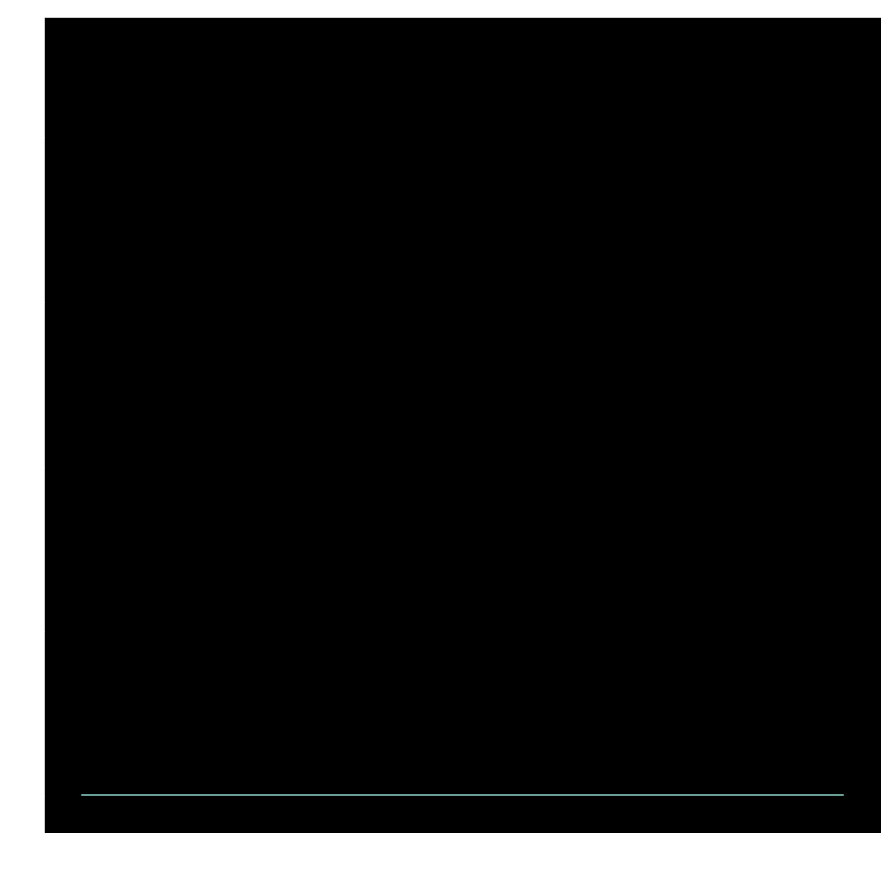

In [49]:
plt.figure(figsize=(15,15))
plt.xlabel('Gaussian Amplitude')
plt.ylabel('RMS')
plt.plot(x_4, y_4, 'o', color='black');
plt.plot(x_4, turb_val, linestyle='-')

#### Random Gaussian noise fft

In [50]:
x_5 = []
y_5 = []
z_5 = []
for ii in range (1, 151):
    noise1 = ii*np.exp(-2j*np.pi*np.random.rand(1000,1000))
    synth_sky_ii = (np.fft.ifft2(np.fft.fft2(synth_sky_50) + noise1)).real
    noise2 = ii*np.exp(-2j*np.pi*np.random.rand(1000,1000))
    synth_stars_ii = (np.fft.ifft2(np.fft.fft2(synth_stars_50) + noise2)).real
    test_no_noise_ii = ((np.fft.ifft2(np.fft.fft2(synth_sky_50))).real - 
                        (np.fft.ifft2(np.fft.fft2(synth_stars_50))).real)
    ಠ_ಠ = ((test_no_noise_ii - turbulent_50)**2).sum()
    test_flux_ii = (synth_sky_ii - synth_stars_ii)
    metric = ((test_flux_ii - turbulent_50)**2).sum()
    x_5.append(ii)
    y_5.append(metric)
    z_5.append(ಠ_ಠ)

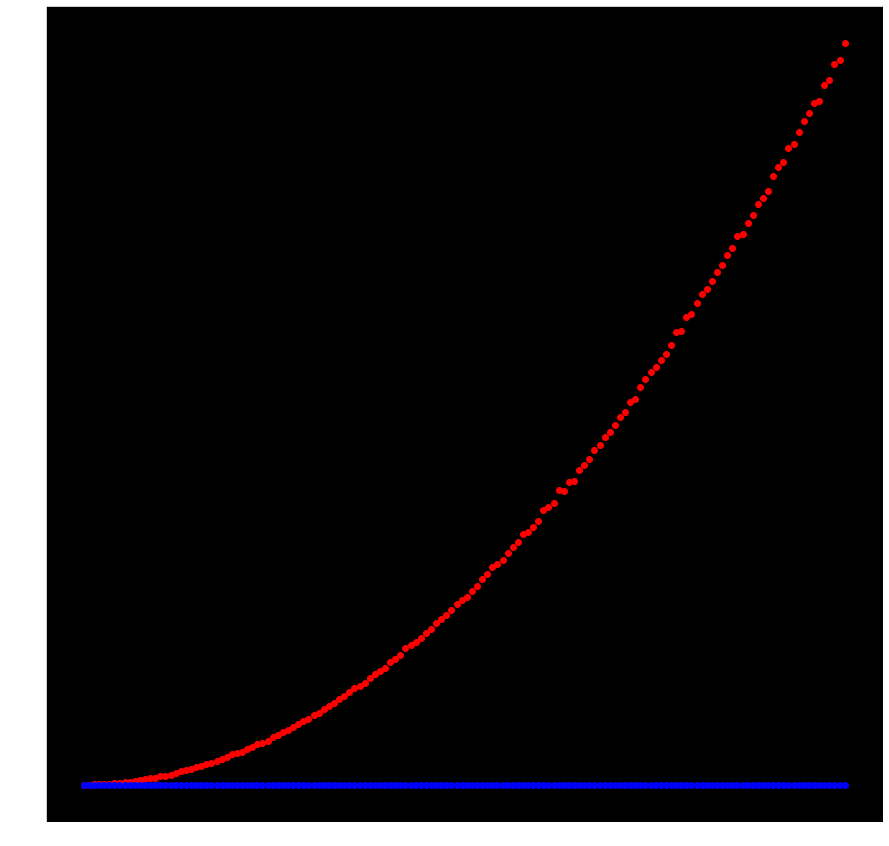

In [51]:
plt.figure(figsize=(15,15))
plt.plot(x_5, y_5, 'o', color='red');
plt.plot(x_5, z_5, "o", color='blue')
#plt.plot(x_5, turb_val, "o", color='red')

#### Poisson Noise

In [75]:
x_6 = []
y_6 = []
error_6 = []
for ii in range (1, 151):
    synth_sky_ii = np.random.poisson(synth_sky_50)
    synth_stars_ii = np.random.poisson(synth_stars_50)
    x_6.append(ii)
    test_flux_ii = (synth_sky_ii - synth_stars_ii)
    ಠ_ಠ = test_flux_ii - turbulent_50
    ㆆ_ㆆ = ((ಠ_ಠ)**2).sum()
    error_adding = np.sqrt(synth_sky_ii + synth_stars_ii)
    error_squaring = np.sqrt(2 * error_adding**2 * ಠ_ಠ**2)
    error_sum = error_squaring.sum()
    y_6.append(ㆆ_ㆆ)
    error_6.append(error_sum)


Text(0, 0.5, 'Residual Square Sum [counts^2]')

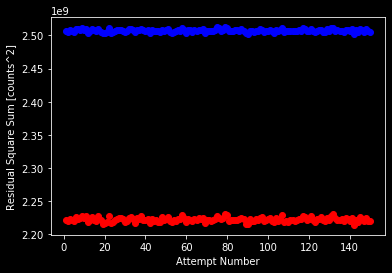

In [76]:
plt.plot(x_6, y_6, 'o', color='red');
plt.plot(x_6, error_6, "o", color='blue')
plt.xlabel('Attempt Number')
plt.ylabel('Residual Square Sum [counts^2]')
#plt.errorbar(x_6, y_6, yerr=error_6, fmt='.k')

In [58]:
sky11 = np.random.poisson(synth_sky_50)
stars22 = np.random.poisson(synth_stars_50)
residue = (sky11 - stars22)

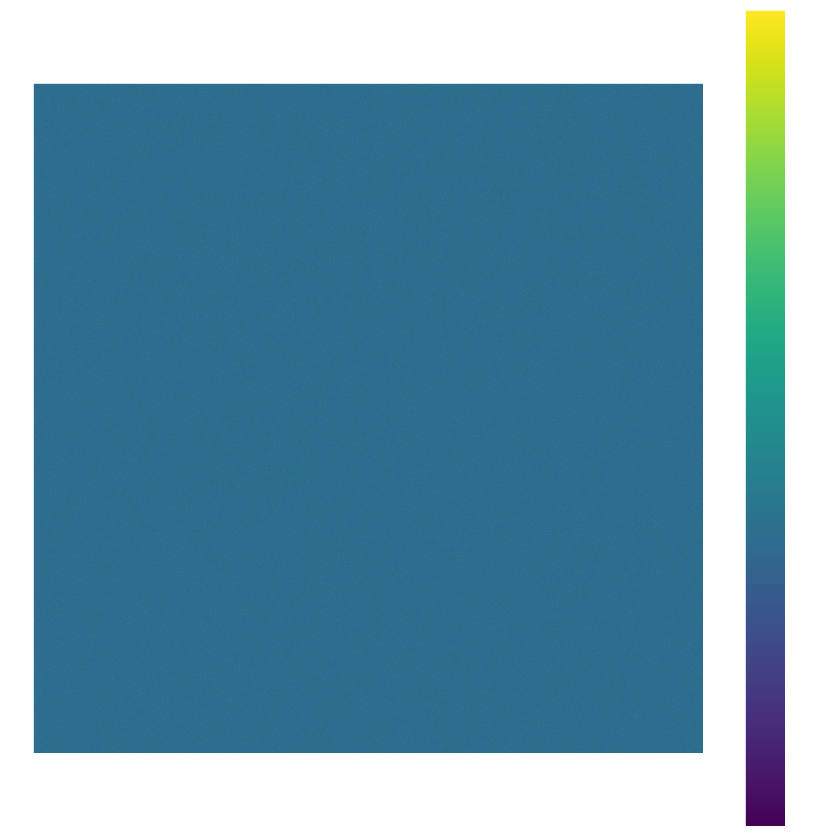

In [59]:
plt.figure(figsize=(15,15))
plt.imshow(residue, interpolation='none', origin='lower', vmax=2500)
plt.colorbar()
plt.show()

In [54]:
wow = np.arange(5)
yike = np.arange(25).reshape(5,5)
wow, yike

(array([0, 1, 2, 3, 4]), array([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]]))

In [55]:
oneD = np.random.poisson(wow)
twoD = np.random.poisson(yike)
oneD, twoD

(array([0, 1, 4, 2, 3]), array([[ 0,  1,  4,  5,  3],
        [ 6,  6,  8,  8, 13],
        [11, 11, 11, 18, 13],
        [14, 22, 13, 23, 19],
        [14, 22, 17, 21, 28]]))